In [1]:
import mxnet as mx
import  matplotlib.pyplot as plt
from skimage import io
from model import get_network
from train2 import load_model
from train2 import get_kitty_data_dir
import time
import numpy as np
#import seaborn as sns
%matplotlib inline
import cv2

/usr/lib/pymodules/python2.7/matplotlib/__init__.py:1173: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
def predict(left_dir,right_dir,epoch):  
    left = io.imread(left_dir).swapaxes(2,1).swapaxes(1,0) - 128.0
    right= io.imread(right_dir).swapaxes(2,1).swapaxes(1,0) - 128.0
    s = (1,3,left.shape[1],left.shape[2])
    ctx = mx.gpu(3)
    net,executor =  load_model('stereo',epoch,s,'fully',ctx)
    args  = dict(zip(net.list_arguments(),executor.arg_arrays))
    args['left'][:] = np.array([left])
    args['right'][:] = np.array([right])
    executor.forward(is_train=False)
    return io.imread(left_dir),io.imread(right_dir),executor.outputs[0].asnumpy()[0],executor.outputs[1].asnumpy()[0]

In [12]:
def work(num,left_dir,right_dir,dis_range):  
    begin = time.time()
    ctx = mx.gpu(3)
    left,right,left_pred,right_pred = predict(left_dir,right_dir,308)
    
    dis_pred = np.zeros((left_pred.shape[1],left_pred.shape[2]))
    
    plt.figure()
    
    
    
    plt.subplot(211)
    io.imshow(left)
    
    for y  in range(left_pred.shape[1]):
        left_embedding = mx.nd.array(left_pred[:,y].T,ctx)
        right_embedding = mx.nd.array(right_pred[:,y],ctx)
        tmp = mx.nd.dot(left_embedding,right_embedding).asnumpy()
        for x in range(left_pred.shape[2]):
            if x - dis_range <0:
                t = 0
            else:
                t = x - dis_range
            dis_pred[y,x] = tmp[x,t:x+1][::-1].argmax()
    
    plt.subplot(212)
    io.imshow(dis_pred)
    plt.xticks()
    plt.title("%f s" % (time.time() - begin),loc='right',)
    plt.axis('off')
    plt.savefig("./pred/%d" % num)

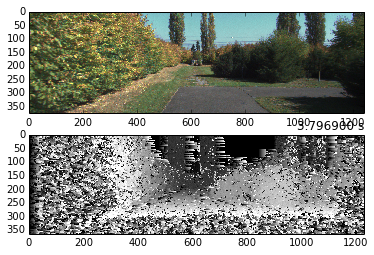

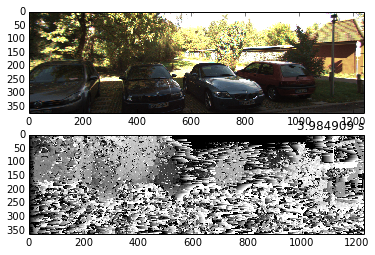

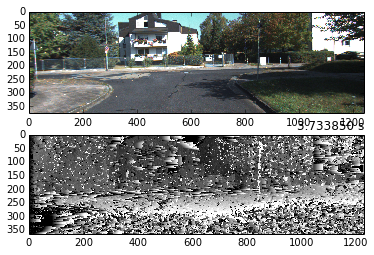

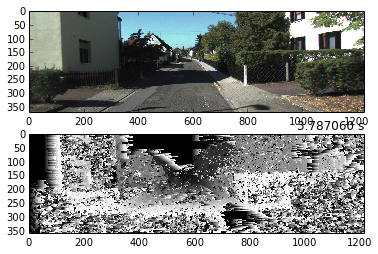

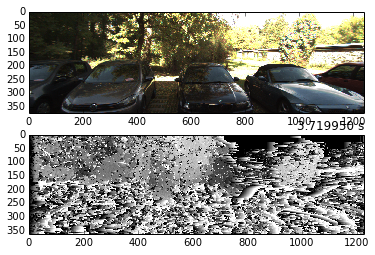

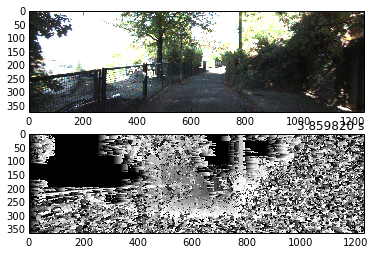

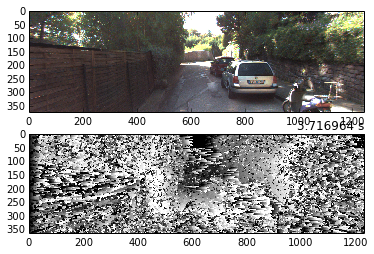

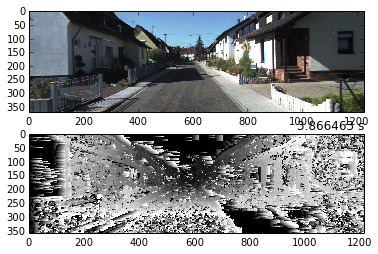

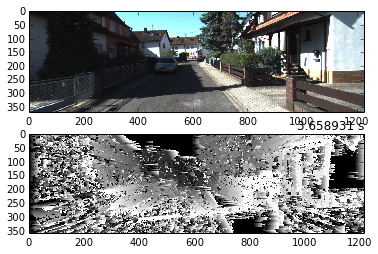

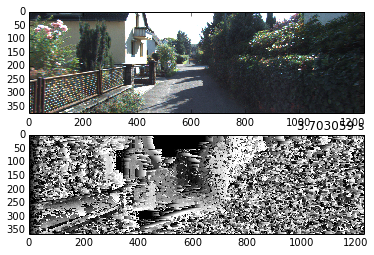

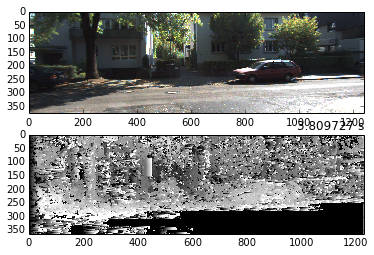

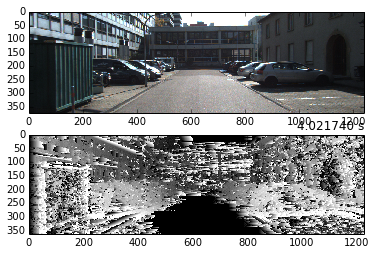

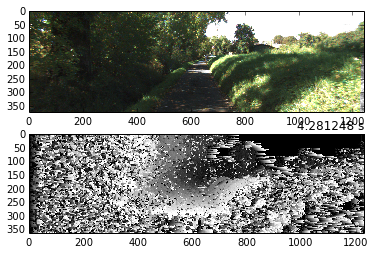

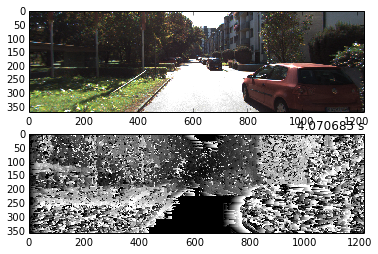

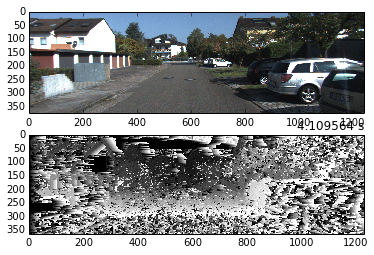

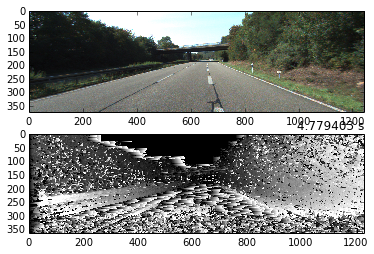

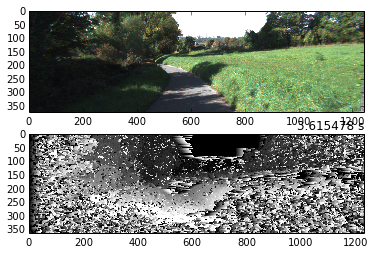

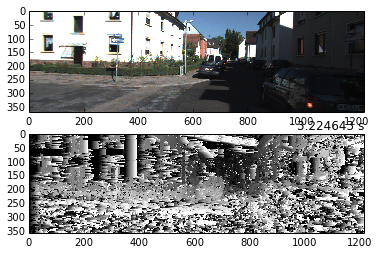

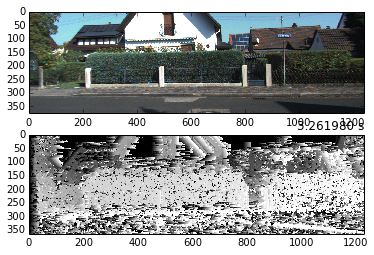

In [11]:
img_dir = get_kitty_data_dir(175,194)
for i,img in enumerate(img_dir):
    work(i,img[1],img[2],40)

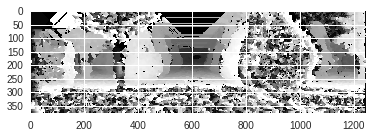

In [86]:
window_size = 16
left = io.imread('./colored_0/000009_10.png')
right = io.imread('./colored_1/000009_10.png')
stereo = cv2.StereoSGBM(minDisparity = 0,
        numDisparities = 32,
        SADWindowSize = 8,
        P1 = 2,
        P2 = 32,
        disp12MaxDiff = 50,
        uniquenessRatio = 1,
        speckleWindowSize = 30,
        speckleRange = 6)
disparity = stereo.compute(left,right)
io.imshow(disparity)

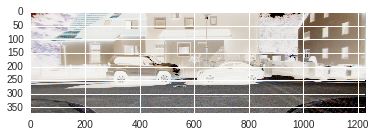

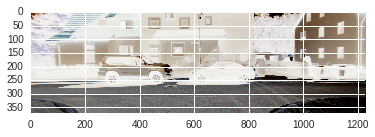

In [34]:
plt.figure()
io.imshow(left.swapaxes(0,1).swapaxes(1,2)+128)
plt.figure()
io.imshow(right.swapaxes(0,1).swapaxes(1,2)+128)

In [30]:
dis_pred[300,1100]

0.0

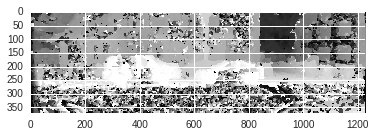

In [38]:
window_size = 16
left = io.imread('./colored_0/000005_10.png')
right = io.imread('./colored_1/000005_10.png')
stereo = cv2.StereoSGBM(minDisparity = 0,
        numDisparities = 32,
        SADWindowSize = 8,
        P1 = 2,
        P2 = 32,
        disp12MaxDiff = 50,
        uniquenessRatio = 1,
        speckleWindowSize = 30,
        speckleRange = 6)
disparity = stereo.compute(left,right)
io.imshow(disparity)

In [7]:
np.random.choice([5 + i for i in range(1,3)])

6

In [13]:
a = [5 + i,5-i for i in range(1,3)]

SyntaxError: invalid syntax (<ipython-input-13-92f78a9e0bfe>, line 1)

In [10]:
a.extend([5-i for i in range(1,3)])

In [17]:
a

[6, 7, 4, 3]

In [19]:
np.random.choice(a)

3